In [10]:
# Function to plot Ellipses of clusters 
# https://stackoverflow.com/questions/12301071/multidimensional-confidence-intervals
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [11]:
import glob
import os
import pandas as pd

bitcoin_df = pd.read_csv('bitcoin_posts.csv')
etherium_df = pd.read_csv('etherium_posts.csv')
litecoin_df = pd.read_csv('litecoin_posts.csv')
neo_df = pd.read_csv('neo_posts.csv')
ripple_df = pd.read_csv('ripple_posts.csv')

bitcoin_df.head()

,username,date,text
0,A1B2C3,"Tuesday, 27 February 2018 at 20:24",Self-Proclaimed Bitcoin Inventor Accused of Sw...
1,awayt1111,"Tuesday, 27 February 2018 at 20:02",we need extra thrust support ignite all the ro...
2,fredwas,"Tuesday, 27 February 2018 at 19:46","Awwrite price bubbas, last little dip and up i..."
3,martmartmac,"Tuesday, 27 February 2018 at 18:34",indian bank fraud fallout spreading lenders no...
4,kyle813018,"Tuesday, 27 February 2018 at 18:27","Enjin Coin will be the ""Ethereum"" of Video Gam..."


In [12]:
doc_list = ['Bitcoin', 'Etherium', 'Litecoin', 'Neo', 'Ripple']

In [13]:
df_list = [bitcoin_df, etherium_df, litecoin_df, neo_df, ripple_df]
corpus = []
coin_names = []

for i in range(len(df_list)):
    current_df = doc_list[i]
    for j in range(df_list[i].shape[0]):
        coin_names.append(current_df)#+ ":" +str(df_list[i]['date'].iloc[j]))
        coin_corpus = str(df_list[i]['text'].iloc[j])
        corpus.append(coin_corpus)

In [14]:
len(corpus), len(coin_names)

(6120, 6120)

# Document Clustering
http://brandonrose.org/clustering

In [15]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
# import mpld3

In [16]:
# Replace apostrohpies - 's and 'nt were being found significant otherwise 
def replace_ap(s):
    new_s = s.replace("'", "")
    new_s = new_s.replace('"', ' ')
    new_s = new_s.replace(',', ' ')
    new_s = new_s.replace('!', ' ')
    new_s = new_s.replace('.com', ' ') # new
    new_s = new_s.replace('. ', ' ')# new
    new_s = new_s.replace('www.', ' ')
    new_s = new_s.replace('...', ' ')
    new_s = new_s.replace('?', ' ')
    new_s = new_s.replace('-', ' ')
    new_s = new_s.replace('_', ' ')
    new_s = new_s.replace('/', ' ')
    new_s = new_s.replace('https', ' ')
    new_s = new_s.replace('http', ' ')
    new_s = " ".join(new_s.split())
    
    return new_s

test = "this is a test's string...I hope it works! if not? oh well. find me at https//www.whatsup.com"
replace_ap(test)

'this is a tests string I hope it works if not oh well find me at whatsup'

In [17]:
# Define function to replace coin name - not interesting 
def replace_coin_name(s):
    s = s.lower()
    new_s = re.sub('bitcoin|litecoin|neo|etherium|ripple|btc|ltc|xrp|eth', ' ',s)
    new_s = " ".join(new_s.split())
    
    return new_s
    
test_str = 'send me some bitcoin ya that btc not that xrp etherium ripple bullshit'
replace_coin_name(test_str)

'send me some ya that not that bullshit'

In [18]:
# corpus[0]

In [19]:
# Remove apostrophies from corpus
corpus_clean = []
for i in range(len(corpus)):
    coin_corpus_clean = replace_ap(corpus[i])
    coin_corpus_clean = replace_coin_name(coin_corpus_clean) # Lets try keeping coin names
    corpus_clean.append(coin_corpus_clean)


In [20]:
# corpus_clean[0]

In [21]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [22]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [23]:

# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [24]:
#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in corpus_clean:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [25]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 210837 items in vocab_frame


In [26]:
# vocab_frame

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=50000,
                                 min_df=0.0002, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_clean) #fit the vectorizer to speeches

print(tfidf_matrix.shape)

Wall time: 6.49 s
(6120, 21467)


C:\Python\lib\site-packages\sklearn\feature_extraction\text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [28]:
terms = tfidf_vectorizer.get_feature_names()
# terms

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

In [30]:
# from equal_groups import EqualGroupsKMeans, k_means # Import custom kmeans 

In [31]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 28.1 s


In [32]:
np.unique(km.labels_)

array([0, 1, 2, 3, 4])

In [33]:
speeches = { 'Coin': coin_names, 'post_content': corpus_clean, 'cluster': clusters}

frame = pd.DataFrame(speeches, index = [clusters] , columns = ['Coin', 'post_content', 'cluster'])
frame.head()

,Coin,post_content,cluster
0,Bitcoin,self proclaimed inventor accused of swindling ...,0
0,Bitcoin,we need extra thrust support ignite all the ro...,0
1,Bitcoin,awwrite price bubbas last little dip and up it...,1
0,Bitcoin,indian bank fraud fallout spreading lenders no...,0
4,Bitcoin,enjin coin will be the ereum of video games ju...,4


In [34]:
frame['Coin'].value_counts()

Neo         1260
Litecoin    1240
Ripple      1220
Etherium    1220
Bitcoin     1180
Name: Coin, dtype: int64

In [35]:
frame['cluster'].value_counts() #number of speeches per cluster (clusters from 0 to 4)

0    3976
4    1431
1     398
2     165
3     150
Name: cluster, dtype: int64

In [36]:
# grouped = frame['Coin'].groupby(frame['cluster']) #groupby cluster for aggregation purposes

# grouped.mean() #average rank (1 to 100) per cluster

In [37]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

top_cluster_words = []

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    current_cluster_top = []
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        current_cluster_top.append(terms[ind])
        print(' %s' % terms[ind], end=',')
#         print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    top_cluster_words.append(current_cluster_top)
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
#     for title in frame.ix[i]['Coin'].values.tolist():
#         print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: news, cryptocurr, just, today, time, crypto,

Cluster 0 titles:

Cluster 1 words: buy, sell, dip, time buy, time, buy buy,

Cluster 1 titles:

Cluster 2 words: nan, сlicҝ, fast correct cautious, fast, fast allow, fast becaus,

Cluster 2 titles:

Cluster 3 words: usd, near, analysi, investorsbuz, outlook, analysi usd,

Cluster 3 titles:

Cluster 4 words: price, like, coin, look, market, just,

Cluster 4 titles:





In [38]:
# terms
# idxs = order_centroids[1, :6]
# idxs
# terms[8292]

# test1 = vocab_frame.loc[terms[8292].split(' ')].values
# np.unique(test1)


# vocab_frame.head()
# vocab_frame.loc[terms[67683].split(' ')].values.tolist()
# vocab_frame.loc[67683]
# vocab_frame.ix[terms[8292].split(' ')].values.tolist()#[0][0].encode('utf-8', 'ignore')
# vocab_frame.ix[terms[idxs[0]]].split(' ')#.values.tolist()[0][0].encode('utf-8', 'ignore')

In [39]:
# Define function to clean the list of top words
def clean_top_words(s):
    s = str(s)
    new_s1 = s.replace("b'", "", 1)
    new_s2 = new_s1.replace("'", "")
    return new_s2

# clean_top_words(top_cluster_words[0][0])
clean_cluster_top = []
for i in range(len(top_cluster_words)):
    current_clean_cluster = []
    for j in range(len(top_cluster_words[i])):
        clean_word = clean_top_words(top_cluster_words[i][j])
        current_clean_cluster.append(clean_word)
    clean_cluster_top.append(current_clean_cluster)
top_cluster_words, clean_cluster_top

([['news', 'cryptocurr', 'just', 'today', 'time', 'crypto'],
  ['buy', 'sell', 'dip', 'time buy', 'time', 'buy buy'],
  ['nan',
   'сlicҝ',
   'fast correct cautious',
   'fast',
   'fast allow',
   'fast becaus'],
  ['usd', 'near', 'analysi', 'investorsbuz', 'outlook', 'analysi usd'],
  ['price', 'like', 'coin', 'look', 'market', 'just']],
 [['news', 'cryptocurr', 'just', 'today', 'time', 'crypto'],
  ['buy', 'sell', 'dip', 'time buy', 'time', 'buy buy'],
  ['nan',
   'сlicҝ',
   'fast correct cautious',
   'fast',
   'fast allow',
   'fast becaus'],
  ['usd', 'near', 'analysi', 'investorsbuz', 'outlook', 'analysi usd'],
  ['price', 'like', 'coin', 'look', 'market', 'just']])

In [40]:
# !!!stop

In [41]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS
from sklearn.manifold import TSNE

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1, n_jobs=-1)
tsne = TSNE(n_components=2, random_state=1)

# pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
pos = tsne.fit_transform(dist)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

In [42]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}
# coin_colors = {'Bitcoin':'#F7931B', 'Etherium':'#112229', 'Litecoin':'#BEBEBE', 
#                'Neo':'8AC81D', 'Ripple':'#019ED5'}
coin_colors = {0:'#F7931B', 1:'#112229', 2:'#BEBEBE', 3:'#8AC81D', 4:'#019ED5'}


#set up cluster names using a dict
# Currently have to manually enter these from the cell above - could fix later 
cluster_names = {0: clean_cluster_top[0], 
                 1: clean_cluster_top[1], 
                 2: clean_cluster_top[2],
                 3: clean_cluster_top[3],
                 4: clean_cluster_top[4]}

# Plot just Clusters

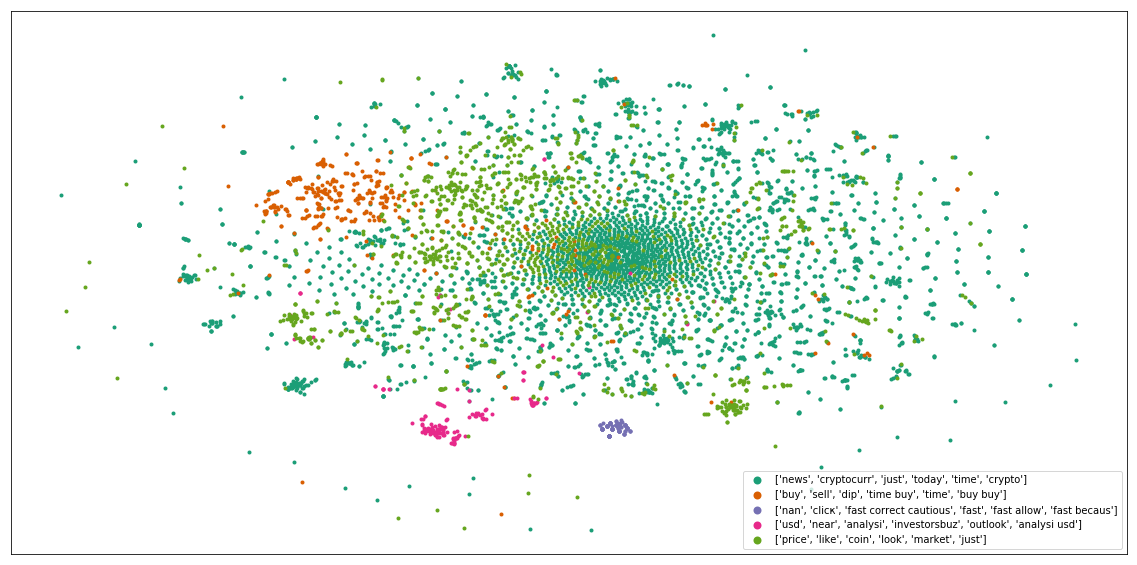

In [43]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=coin_names)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1, markerscale=2)  #show legend with only 1 point

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=2)  

    
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

plt.show() #show the plot

In [44]:
len(coin_names)

6120

# Plot Clusters with coin colors 

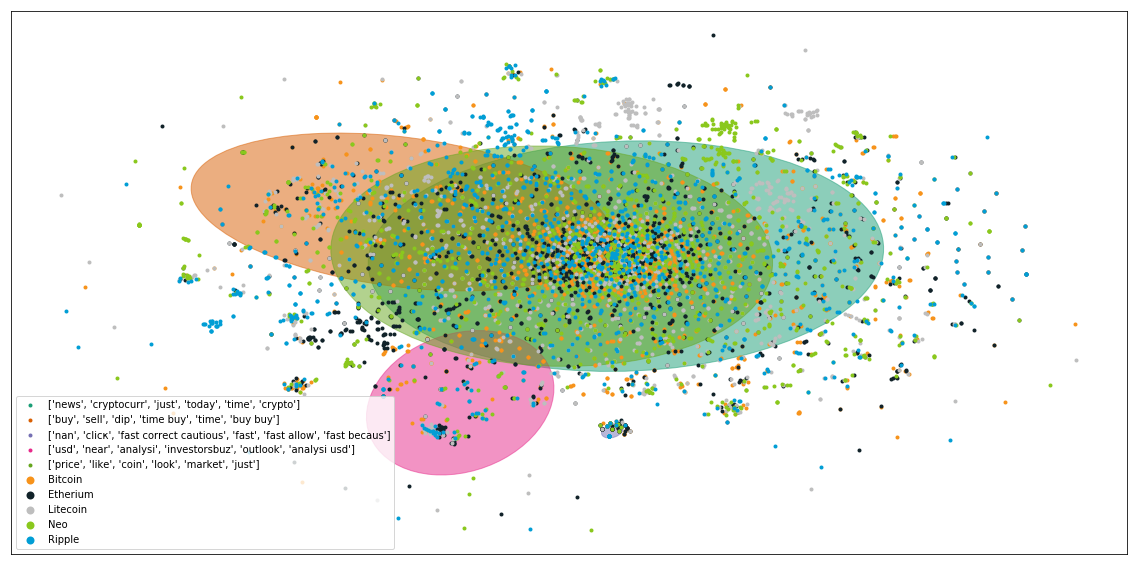

In [58]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=coin_names)) 

test = df.copy()
test['coin_name'] = test['title'].map({'Bitcoin':0, 'Etherium':1, 'Litecoin':2, 
               'Neo':3, 'Ripple':4})

coin_plot_names = {0:'Bitcoin', 1:'Etherium', 2:'Litecoin', 3:'Neo', 4:'Ripple'}

#group by cluster
# groups = test.groupby('label')

#group by coin
groups = test.groupby('coin_name')


# set up plot
fig, ax = plt.subplots(figsize=(20, 10)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

# Group by cluster - for plotting cluster ellipses 
group2 = test.groupby('label')
for name, group in group2:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=2, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    plot_point_cov(np.asarray(list(zip(group.x,group.y))), nstd=1.5, alpha=0.5, color=cluster_colors[name])

    
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=4, 
            label=coin_plot_names[name], color=coin_colors[name], 
            mec='none')
#     ax.plot(group.x, group.y, marker='o', linestyle='', ms=0, 
#             label=cluster_names[name], color=cluster_colors[name], 
#             mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    

ax.legend(numpoints=1, markerscale=2)  #show legend with only 1 point
# ax.legend(coin_colors, ['Bitcoin', 'Etherium', 'Litecoin', 'Neo', 'Ripple'])

#add label in x,y position with the label as the film title
# for i in range(len(df)):
#     ax.text(df.iloc[i]['x'], df.iloc[i]['y'], df.iloc[i]['title'], size=2)  

plt.savefig('clusters_coin.png', dpi=200)

In [46]:
# stop = 0
# for WHAT, group in groups:
#     if stop >= 10:
#         break
#     print(group)
#     stop +=1

In [47]:
# np.asarray(list(zip(x,y)))

In [48]:
# Find the number of coins in each cluster 
for cluster in df['label'].unique():
    temp_df = df.loc[df['label'] == cluster]
    print('Total number in cluster', cluster, temp_df.shape[0])
    print('Top words for cluster', cluster, ':', clean_cluster_top[cluster])
    print('Total Bitcoin in cluster', cluster, temp_df.loc[temp_df['title'] == 'Bitcoin'].shape[0], temp_df.loc[temp_df['title'] == 'Bitcoin'].shape[0]/temp_df.shape[0])
    print('Total Etherium in cluster', cluster, temp_df.loc[temp_df['title'] == 'Etherium'].shape[0], temp_df.loc[temp_df['title'] == 'Etherium'].shape[0]/temp_df.shape[0])
    print('Total Litecoin in cluster', cluster, temp_df.loc[temp_df['title'] == 'Litecoin'].shape[0], temp_df.loc[temp_df['title'] == 'Litecoin'].shape[0]/temp_df.shape[0])
    print('Total Neo in cluster', cluster, temp_df.loc[temp_df['title'] == 'Neo'].shape[0], temp_df.loc[temp_df['title'] == 'Neo'].shape[0]/temp_df.shape[0])
    print('Total Ripple in cluster', cluster, temp_df.loc[temp_df['title'] == 'Ripple'].shape[0], temp_df.loc[temp_df['title'] == 'Ripple'].shape[0]/temp_df.shape[0])
    print()
    print()

Total number in cluster 0 3976
Top words for cluster 0 : ['news', 'cryptocurr', 'just', 'today', 'time', 'crypto']
Total Bitcoin in cluster 0 780 0.19617706237424548
Total Etherium in cluster 0 774 0.19466800804828974
Total Litecoin in cluster 0 798 0.2007042253521127
Total Neo in cluster 0 889 0.22359154929577466
Total Ripple in cluster 0 735 0.18485915492957747


Total number in cluster 1 398
Top words for cluster 1 : ['buy', 'sell', 'dip', 'time buy', 'time', 'buy buy']
Total Bitcoin in cluster 1 84 0.21105527638190955
Total Etherium in cluster 1 65 0.16331658291457288
Total Litecoin in cluster 1 97 0.24371859296482412
Total Neo in cluster 1 85 0.2135678391959799
Total Ripple in cluster 1 67 0.16834170854271358


Total number in cluster 4 1431
Top words for cluster 4 : ['price', 'like', 'coin', 'look', 'market', 'just']
Total Bitcoin in cluster 4 269 0.18798043326345212
Total Etherium in cluster 4 271 0.1893780573025856
Total Litecoin in cluster 4 287 0.20055904961565338
Total Neo i

Get 5 most important words from each forum
Use those as the points on the plot, colored according to the forum they came from 
Plot Elipses for clusters 

In [59]:
df_list = [bitcoin_df, etherium_df, litecoin_df, neo_df, ripple_df]
corpus = []
coin_names = []

for i in range(len(df_list)):
    current_df = doc_list[i]
    for j in range(df_list[i].shape[0]):
        coin_names.append(current_df)#+ ":" +str(df_list[i]['date'].iloc[j]))
        coin_corpus = str(df_list[i]['text'].iloc[j])
        corpus.append(coin_corpus)
        
bitcoin_forum = ""
etherium_forum = ""
litecoin_forum = ""
neo_forum = ""
ripple_forum = ""

for i in range(bitcoin_df.shape[0]):
    bitcoin_forum += str(bitcoin_df['text'].iloc[i]) + " "
for i in range(etherium_df.shape[0]):
    etherium_forum += str(etherium_df['text'].iloc[i]) + " "
for i in range(litecoin_df.shape[0]):
    litecoin_forum += str(litecoin_df['text'].iloc[i]) + " "
for i in range(neo_df.shape[0]):
    neo_forum += str(neo_df['text'].iloc[i]) + " "
for i in range(ripple_df.shape[0]):
    ripple_forum += str(ripple_df['text'].iloc[i]) + " "
    
len(bitcoin_forum), len(etherium_forum), len(litecoin_forum), len(neo_forum), len(ripple_forum)

(216516, 263900, 232836, 236287, 352759)

In [60]:
# Clean the forum posts 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def clean_and_tokenize(s):

    s = s.lower()
    s = replace_ap(s)
    s = replace_coin_name(s)
#     s_clean = s
#     s_clean = re.sub(',|.|?|!|http|https|"', ' ',s)

    stop_words = set(stopwords.words('english'))
#     stop_words = list(stop_words)
#     exclusions = '|'.join(stop_words)
#     s_clean = re.sub(exclusions, ' ', s)
    
#     return s_clean

    word_tokens = word_tokenize(s)

#     filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = []

    for w in word_tokens:
        if w not in stop_words:
            filtered_sentence.append(w)
#     for w in s:
#         if w not in stop_words:
#             filtered_sentence.append(w)

    return (" ".join(filtered_sentence))

In [61]:
bitcoin_forum = clean_and_tokenize(bitcoin_forum)
etherium_forum = clean_and_tokenize(etherium_forum)
litecoin_forum = clean_and_tokenize(litecoin_forum)
neo_forum = clean_and_tokenize(neo_forum)
ripple_forum = clean_and_tokenize(ripple_forum)

In [62]:
len(bitcoin_forum), len(etherium_forum), len(litecoin_forum), len(neo_forum), len(ripple_forum)

(142699, 176329, 146353, 152026, 227821)

In [63]:
bitcoin_forum[0:100]

'self proclaimed inventor accused swindling $ 5 billion cryptocurrency : koinalert self proclaimed in'

In [64]:
import math
from textblob import TextBlob as tb

def tf(word, blob):
    return blob.words.count(word) / len(blob.words)

def n_containing(word, bloblist):
    return sum(1 for blob in bloblist if word in blob.words)

def idf(word, bloblist):
    return math.log(len(bloblist) / (1 + n_containing(word, bloblist)))

def tfidf(word, blob, bloblist):
    return tf(word, blob) * idf(word, bloblist)

In [65]:
bitcoin_forum = tb(bitcoin_forum)
etherium_forum = tb(etherium_forum)
litecoin_forum = tb(litecoin_forum)
neo_forum = tb(neo_forum)
ripple_forum = tb(ripple_forum)

In [66]:
bloblist = [bitcoin_forum, etherium_forum, litecoin_forum, neo_forum, ripple_forum]
for i, blob in enumerate(bloblist):
    print("Top words in document {}".format(i + 1))
    scores = {word: tfidf(word, blob, bloblist) for word in blob.words} # replace tfidf with just tf
    sorted_words = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    for word, score in sorted_words[:5]:
        print("\tWord: {}, TF-IDF: {}".format(word, round(score, 5)))

Top words in document 1
	Word: 12k, TF-IDF: 0.00049
	Word: mkt, TF-IDF: 0.00039
	Word: candle, TF-IDF: 0.00039
	Word: 9800, TF-IDF: 0.00035
	Word: multitrillion, TF-IDF: 0.00031
Top words in document 2
	Word: img, TF-IDF: 0.00052
	Word: inputs, TF-IDF: 0.0005
	Word: gulden, TF-IDF: 0.00043
	Word: nuclear, TF-IDF: 0.00043
	Word: payable, TF-IDF: 0.00043
Top words in document 3
	Word: lcc, TF-IDF: 0.003
	Word: 215, TF-IDF: 0.00067
	Word: charlie, TF-IDF: 0.0006
	Word: issuers, TF-IDF: 0.00042
	Word: imprudent, TF-IDF: 0.00037
Top words in document 4
	Word: ontology, TF-IDF: 0.00152
	Word: °, TF-IDF: 0.00151
	Word: org, TF-IDF: 0.00144
	Word: nex, TF-IDF: 0.00098
	Word: meetup, TF-IDF: 0.00098
Top words in document 5
	Word: union, TF-IDF: 0.00179
	Word: xrapid, TF-IDF: 0.00173
	Word: swift, TF-IDF: 0.00131
	Word: xcurrent, TF-IDF: 0.00081
	Word: saudi, TF-IDF: 0.00081
